# Clasifikasi Menggunakan Dataset CIFAR-10

[Dataset](https://github.com/YoongiKim/CIFAR-10-images)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchmetrics.classification import Accuracy
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
import os

# Periksa isi direktori root dataset Anda
base_path = '/kaggle/input/'
print(f"Isi dari {base_path}:")
print(os.listdir(base_path))

# Jika ada sub-direktori lain di dalamnya, periksa juga
# Contoh: jika listdir(base_path) menunjukkan ada folder 'CIFAR-10-original'
# Maka Anda perlu memeriksa isinya
# print(f"\nIsi dari {os.path.join(base_path, 'CIFAR-10-original')}:")
# print(os.listdir(os.path.join(base_path, 'CIFAR-10-original')))

# Cara yang lebih menyeluruh untuk melihat struktur (direkomendasikan):
# print("\nStruktur direktori lengkap:")
# for dirpath, dirnames, filenames in os.walk(base_path):
#     print(f'Directory: {dirpath}')
#     print(f'  Subdirectories: {dirnames}')
#     # print(f'  Files (first 5): {filenames[:5]}') # Uncomment if you want to see files too
#     print('---')

Isi dari /kaggle/input/:
['cifar-10-image']


# dataset dan dataloader

In [3]:
bs = 64
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
generator = torch.Generator().manual_seed(42)

train_set = datasets.ImageFolder(root='/kaggle/input/cifar-10-image/CIFAR-10/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)
test_set = datasets.ImageFolder(root='/kaggle/input/cifar-10-image/CIFAR-10/test', transform=test_transform)
test_set, val_set = random_split(
    test_set,
    [0.5, 0.5],
    generator=generator
)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)
val_loader = DataLoader(val_set, batch_size=bs, shuffle=False)

In [4]:
label2cat, idxclass = train_set.classes, train_set.class_to_idx
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
test_set

In [6]:
train_set

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /kaggle/input/cifar-10-image/CIFAR-10/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
feature, target = next(iter(train_loader))
feature.shape, target.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

# arsitektur dan config
## transfer learning

In [8]:
def conv_block(in_feature, out_feature, padding=1, stride=1,
                  activation="relu", pool =True, maxpool=True, kernel_size=3,
                  kernel_size_pool=2, pool_stride=2)-> list[nn.Sequential]:
    layers = [nn.Conv2d(in_feature, out_feature, kernel_size=kernel_size, padding=padding, stride=stride)]
    if activation == "relu":
        layers.append(nn.ReLU())
    elif activation == "leakyrelu":
        layers.append(nn.LeakyReLU())
    elif activation == "sigmoid":
        layers.append(nn.Sigmoid())
    elif activation == "tanh":
        layers.append(nn.Tanh())
    if pool:
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=kernel_size_pool, stride=pool_stride))
        else:
            layers.append(nn.AvgPool2d(kernel_size=kernel_size_pool, stride=pool_stride))
    else:
        layers.append(nn.Identity())
    return nn.Sequential(*layers)



def linear_block(in_features, out_features, activation=None, dropout=0.0):
    layers = [nn.Linear(in_features, out_features)]
    # if batch_norm:
    #     layers.append(BatchNorm1d(out_features))
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'leakyrelu':
        layers.append(nn.LeakyReLU())
    elif activation == 'softmax':
        layers.append(nn.Softmax(dim=1))
    elif activation == 'elu':
        layers.append(nn.ELU())
    elif activation == 'selu':
        layers.append(nn.SELU())
    elif activation == 'lsoftmax':
        layers.append(nn.LogSoftmax(dim=1))
    if dropout > 0.0:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)


In [9]:
class TransferLearningModel(pl.LightningModule):
    def __init__(self, num_classes, dropout=0.0):
        super(TransferLearningModel, self).__init__()
        self.save_hyperparameters()
        self.feature_extractor = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.freeze()
        num_ftrs = self.feature_extractor.classifier[1].in_features
        self.feature_extractor.classifier[1] = nn.Linear(num_ftrs, num_classes) 
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    def forward(self, x):
        return self.feature_extractor(x)

    def freeze(self):
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self, lr=0.001):
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        return optimizer


In [10]:
model = TransferLearningModel(len(label2cat)).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 145MB/s]


In [11]:
best_val_accuracy = 0.0 
patience = 5
epochs_no_improve = 0

In [12]:
if torch.cuda.is_available():
    accelerator_type = 'gpu'
    devices_to_use = 1 
else:
    accelerator_type = 'cpu'
    devices_to_use = 'auto' 

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='cifar10-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
)
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer1 = pl.Trainer(
    max_epochs=25,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor_callback],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="simple_model_experiment"),
    accelerator=accelerator_type,  
    devices=devices_to_use,     
    log_every_n_steps=10
)

In [13]:
print("\nMemulai pelatihan CNN dengan PyTorch Lightning...")
trainer1.fit(model, train_loader, val_loader)

print("\nPelatihan CNN selesai dengan PyTorch Lightning.")
print(f"Model CNN terbaik disimpan di: {checkpoint_callback.best_model_path}")


Memulai pelatihan CNN dengan PyTorch Lightning...


2025-07-27 09:13:53.116728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753607633.290126      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753607633.341544      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Pelatihan CNN selesai dengan PyTorch Lightning.
Model CNN terbaik disimpan di: /kaggle/working/checkpoints/cifar10-epoch=01-val_loss=1.05.ckpt


# fine-tuning

In [15]:
best_model_path_fase1 = checkpoint_callback.best_model_path
if best_model_path_fase1:
    model_fine_tune = TransferLearningModel.load_from_checkpoint(best_model_path_fase1)
    print(f"Model dimuat dari checkpoint terbaik Fase 1: {best_model_path_fase1}")
else:
    model_fine_tune = model # Jika tidak ada checkpoint terbaik, gunakan model terakhir dari Fase 1
    print("Tidak ada checkpoint terbaik dari Fase 1, melanjutkan dari model terakhir.")

model.unfreeze()
model.configure_optimizers(lr=1e-4)

checkpoint_callback_fase2 = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/', 
    filename='model-fase2-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)
early_stopping_fase2 = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    mode='min'
)
lr_monitor_fase2 = LearningRateMonitor(logging_interval='epoch')

trainer_fase2 = pl.Trainer(
    max_epochs=50, 
    callbacks=[checkpoint_callback_fase2, early_stopping_fase2, lr_monitor_fase2],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="fase2_fine_tuning"),
    accelerator=accelerator_type,
    devices=devices_to_use,
    log_every_n_steps=10
)

trainer_fase2.fit(model_fine_tune, train_loader, val_loader)

Model dimuat dari checkpoint terbaik Fase 1: /kaggle/working/checkpoints/cifar10-epoch=01-val_loss=1.05.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# predict

Model berhasil dimuat dari: /kaggle/working/checkpoints/model-fase2-epoch=19-val_loss=0.99.ckpt
Model dipindahkan ke cuda dan diatur ke mode evaluasi.
DataLoader untuk inferensi siap. Jumlah gambar: 5000
Berhasil memprediksi 64 gambar.
Nama kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


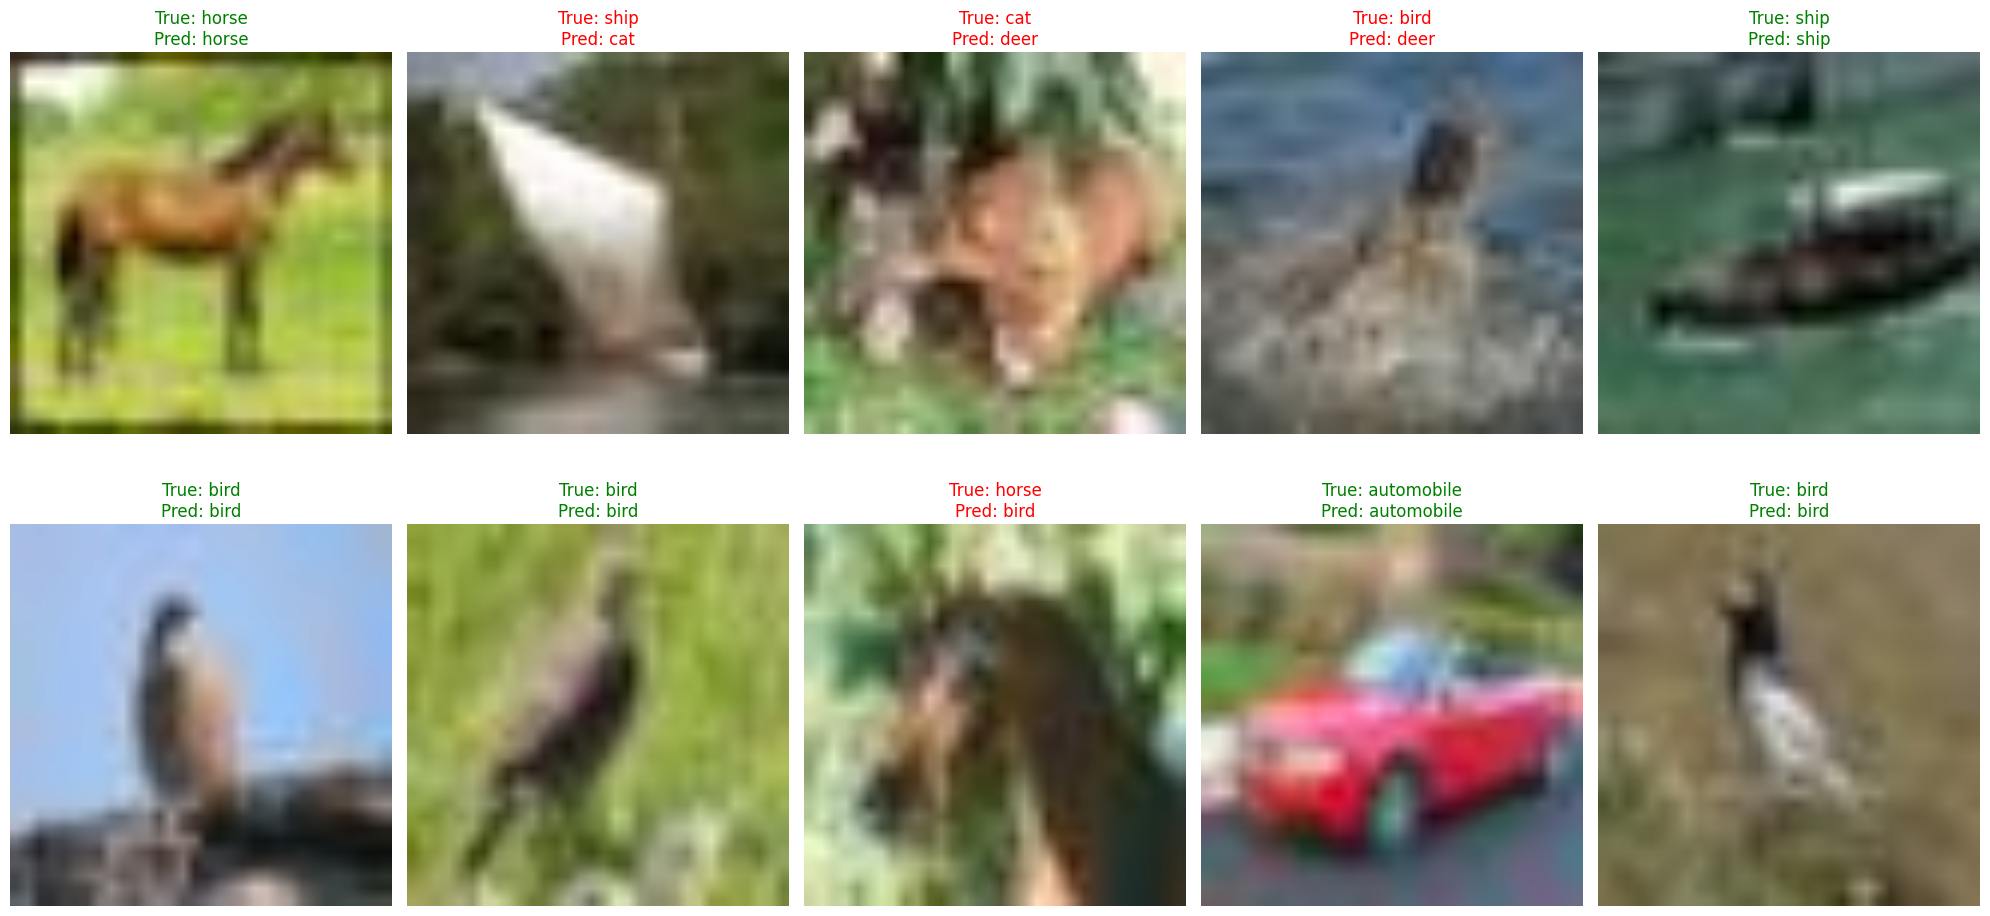


Visualisasi prediksi selesai.


In [20]:
best_checkpoint_path = checkpoint_callback_fase2.best_model_path 
num_classes_cifar10 = 10 

try:
    model = TransferLearningModel.load_from_checkpoint(best_checkpoint_path, num_classes=num_classes_cifar10)
    print(f"Model berhasil dimuat dari: {best_checkpoint_path}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print(f"Model dipindahkan ke {device} dan diatur ke mode evaluasi.")

except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {best_checkpoint_path}.")
    print("Pastikan path dan nama file checkpoint benar dan sudah di-save ke Kaggle /kaggle/working/checkpoints/.")
    model = TransferLearningModel(num_classes=num_classes_cifar10)
    model.to(device)
    model.eval()
    print("Menggunakan model yang tidak dilatih karena checkpoint tidak ditemukan.")
except Exception as e:
    print(f"Terjadi kesalahan saat memuat atau menyiapkan model: {e}")
    model = TransferLearningModel(num_classes=num_classes_cifar10)
    model.to(device)
    model.eval()
    print(f"Terjadi kesalahan: {e}. Menggunakan model yang tidak dilatih sebagai fallback.")




print(f"DataLoader untuk inferensi siap. Jumlah gambar: {len(test_set)}")

# --- 4. Melakukan Prediksi dan Mengumpulkan Hasil ---
all_images = []
all_labels = []
all_preds = []

num_batches_to_predict = 1 

with torch.no_grad(): 
    for i, (images, labels) in enumerate(test_loader):
        if i >= num_batches_to_predict:
            break

        images = images.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_preds.append(predicted_labels.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

print(f"Berhasil memprediksi {len(all_images)} gambar.")

# --- 5. Memvisualisasikan Prediksi ---

# Dapatkan nama kelas dari dataset
class_names = train_set.classes
print(f"Nama kelas: {class_names}")

def imshow(inp, title=None):
    """Menampilkan tensor sebagai gambar."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Un-normalisasi
    inp = np.clip(inp, 0, 1) # Pastikan nilai piksel di antara 0 dan 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Plot beberapa gambar dengan prediksi
num_images_to_show = min(10, len(all_images)) # Tampilkan maksimal 10 gambar

fig = plt.figure(figsize=(20, 10)) # Ukuran figure lebih besar
for i in range(num_images_to_show):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[]) # 2 baris, 5 kolom
    imshow(all_images[i])

    true_label = class_names[all_labels[i]]
    predicted_label = class_names[all_preds[i]]
    
    # Warna teks berdasarkan kebenaran prediksi
    color = "green" if predicted_label == true_label else "red"
    
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout() # Penyesuaian layout agar tidak tumpang tindih
plt.show()

print("\nVisualisasi prediksi selesai.")

In [ ]:
import os
import shutil

# Definisikan nama file ZIP yang ingin Anda buat
output_zip_name = 'my_model_outputs.zip'

# Tentukan direktori yang ingin Anda kompres
# Biasanya /kaggle/working jika Anda ingin semua output
output_directory = '/kaggle/working/'

# Kompres direktori menjadi file ZIP
# shutil.make_archive(base_name, format, root_dir)
# 'base_name' adalah path dan nama file ZIP tanpa ekstensi
# 'format' adalah 'zip'
# 'root_dir' adalah direktori yang akan dikompres
shutil.make_archive(os.path.join(output_directory, output_zip_name.split('.')[0]), 'zip', output_directory)

print(f"File output Anda telah dikompres ke: {os.path.join(output_directory, output_zip_name)}")

# Anda bisa menambahkan ini ke akhir notebook Anda.
# Setelah ini dieksekusi, ikuti Metode 1 untuk mengunduh 'my_model_outputs.zip'